**Setup your google drive to use it for python**



Run the following lines with Shift+Enter and then go to the URL and type your google credentials.

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install -q pandas

To install pytorch we have to add the url because it is not standard in Colab:



In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.0-{platform}-linux_x86_64.whl torchvision

Now we can start with a very simple Neural network. For this download the Ising data from [Github](https://github.com/PatrickHuembeli/QML-Course-UPC-2018/blob/master/L_10_data.zip) and put it in a folder of your google drive.

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import os
import pickle

Upload RBM_helper here

In [0]:
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


def outer_product(vecs1, vecs2):
    # A way to calculate outer vector products in torch
    return torch.bmm(vecs1.unsqueeze(2), vecs2.unsqueeze(1)) 

class RBM(nn.Module):
    def __init__(self,
                 n_vis=10,
                 n_hin=50,
                 k=5, gpu = False, saved_weights = None):
        super(RBM, self).__init__()
        self.gpu = gpu
        if saved_weights is None:
            self.W = nn.Parameter(torch.randn(n_hin,n_vis)*1e-2, requires_grad = True) # randomly initialize weights
            self.v_bias = nn.Parameter(torch.randn(n_vis)*1e-2, requires_grad=True)
            self.h_bias = nn.Parameter(torch.randn(n_hin)*1e-2, requires_grad=True)
        else:
            self.W = saved_weights[0]
            self.v_bias = saved_weights[1]
            self.h_bias = saved_weights[2]
        self.k = k
        self.n_vis = n_vis
        
        self.W_update = self.W.clone()
        self.h_bias_update = self.h_bias.clone()
        self.v_bias_update = self.v_bias.clone()
        
        if self.gpu:
            self.W_update = self.W_update.cuda()
            self.v_bias_update = self.v_bias_update.cuda()
            self.h_bias_update = self.h_bias_update.cuda()

    #--------------------------------------------------------------------------
    # What does this code do? 
    def v_to_h(self,v): # sample h, given v
        """This chunk of code samples the hidden layer given the visible layer.
        It estimates the probabilities that a hidden node h has a certain value
        given that a visual node v has been determined. The estimation is done by means
        of a sigmoid. It returns the eestimated probabilities and the estimated values
        for the hidden layer."""
        # Checking wther cuda cores are accessible
        if (self.gpu and not v.is_cuda):
            v = v.cuda()
        # Sampling the probability of hidden from the visible
        p_h = F.sigmoid(F.linear(v,self.W,self.h_bias))
        # p (h_j | v ) = sigma(b_j + sum_i v_i w_ij)
        # Sampling h using a Bernoulli distribution with p(h|v) just obtained
        sample_h = p_h.bernoulli()
        return p_h, sample_h

    #--------------------------------------------------------------------------
    # What does this code do?     
    def h_to_v(self,h): # sample v given h
        """This chunk samples the visible layer given the values of the hidden layer.
        The function returns the sampled visible layer and the probability in which 
        this state has occured."""
        # Checking wther cuda cores are accessible
        if (self.gpu and not h.is_cuda):
            h = h.cuda()
        # Sampling the probabilities of visible given hidden
        p_v = F.sigmoid(F.linear(h,self.W.t(),self.v_bias))
        # p (v_i | h ) = sigma(a_i + sum_j h_j w_ij)
        # Sampling the values of visible for this iteration using
        # the Bernouilli distribution with p(v|h)
        sample_v = p_v.bernoulli()
        return p_v, sample_v
    
    def forward(self,v): 
        if (self.gpu and not v.is_cuda):
            v = v.cuda()
        p_h, h1 = self.v_to_h(v)
        h_ = h1
        for _ in range(self.k):
            _, v_ = self.h_to_v(h_)
            _, h_ = self.v_to_h(v_)
        return v,v_
        
    def free_energy(self,v): 
        if (self.gpu and not v.is_cuda):
            v = v.cuda()
        if len(v.shape)<2: #if v is just ONE vector
            v = v.view(1, v.shape[0])
        vbias_term = v.mv(self.v_bias) 
        wx_b = F.linear(v,self.W,self.h_bias) 
        hidden_term = wx_b.exp().add(1).log().sum(1) 
        return (-hidden_term - vbias_term) 

    #--------------------------------------------------------------------------
    # What does this code do?     
    def draw_sample(self, sample_length, number_of_samples = 10, initial_im=[]):
        """Random sample drawing. Asks the RBM for a state and it generates one,
        following the trained probabilities for each state. We can select
        to provide a visible layer of our choosing."""
        if len(initial_im) == 0:
            # Starting with a random vector in the visible layer
            v_ = F.relu(torch.sign(torch.randn([number_of_samples, self.n_vis])))
            for _ in range(sample_length):
                # Doing a step in Gibbs sampling
                _, h_ = self.v_to_h(v_)
                _, v_ = self.h_to_v(h_)
        else:
            # Using an example state as the first step
            v_ = initial_im
            for _ in range(sample_length):
                # Gibbs sampling
                _, h_ = self.v_to_h(v_)
                _, v_ = self.h_to_v(h_)
        return v_
    
    # -------------------------------------------------------------------------
    def partition_fct(self, spins):
        return (-self.free_energy(spins)).exp().sum()

    def probability_of_v(self, all_spins, v):
        epsilon = (-self.free_energy(v)).exp().sum()
        Z = self.partition_fct(all_spins)
        return epsilonW/Z

    #--------------------------------------------------------------------------
    # What does this code do?    
    def train(self, train_loader, lr= 0.01, weight_decay=0, momentum=0.9, epoch=0):
        """Training function for the RBM. First, the training data is loaded. We then
        get the positive and negative phases of the current training step:
            -The positive phase increases the probability of training by reducing
            the free energy.
            -The negative phase reduces the probability of the samples generated by
            the model, so that only those approaching the empirical p(v, h) are
            significant.
        Between this, we make the next step on the Gibbs sampling, obtaining
        the next values of the hidden parameters. After this, we accelerate
        the training by modifying the biases and connections between the two
        layers by a certain predefined quantity. Finally, we calculate the
        next increment on the biases and connections and sum them to those
        of the previous step."""
        loss_ = []
        for _, data in enumerate(train_loader):
            self.data = Variable(data.view(-1,self.n_vis))
            if self.gpu:
                self.data = self.data.cuda()
            
            # Get positive phase from the data
            self.vpos = self.data
            self.hpos_probability, self.hpos = self.v_to_h(self.vpos)
            # Get negative phase from the chains
            _, self.vneg = self.forward(self.vpos) # make actual k-step sampling
            self.hneg_probability, self.hneg = self.v_to_h(self.vneg)
        
            self.W_update.data      *= momentum
            self.h_bias_update.data *= momentum
            self.v_bias_update.data *= momentum
            
            # Icrements for this iteration on connections and biases
            self.deltaW = (outer_product(self.hpos_probability, self.vpos)- outer_product(self.hneg_probability, self.vneg)).data.mean(0)
            self.deltah = (self.hpos_probability - self.hneg_probability).data.mean(0)
            self.deltav = (self.vpos - self.vneg).data.mean(0)
            # mean averages over all batches
            # Checking if cuda cores are available
            if self.gpu:
                # Updating the values of the connections and biases
                self.W_update.data      += (lr * self.deltaW).cuda()
                self.h_bias_update.data += (lr * self.deltah).cuda()
                self.v_bias_update.data += (lr * self.deltav).cuda()
            else:
                # Updating the values of the connections and biases
                self.W_update.data      += (lr * self.deltaW)
                self.h_bias_update.data += (lr * self.deltah)
                self.v_bias_update.data += (lr * self.deltav)

                    
            self.W.data      += self.W_update.data
            self.h_bias.data += self.h_bias_update.data
            self.v_bias.data += self.v_bias_update.data
            # Mean square error for this iteration
            loss_.append(F.mse_loss(self.vneg, self.vpos).data[0])


In [0]:
path = 'drive/My Drive/RBM_collab/Gaussian_Data/'

**This is the whole RBM training routine**

In [0]:
batch_size = 64
#epochs = 500 # More epochs test
epochs = 41
gpu = True

## Loading the images from the file
data = np.load(path + 'gauss.npy')   
dims = data.shape
data = torch.FloatTensor(data)

## Starting the Machinery
vis = dims[1]   # Number of visible layers
hid = vis
k = 1
rbm = RBM(n_vis=vis, n_hin=hid, k=k, gpu=gpu) #Creation of the RBM

In [36]:
# Trying to set up GPU acceleration
if gpu:
    rbm = rbm.cuda()
 
train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
        shuffle=True)

for epoch in range(epochs):
    # loading data into the RBM
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,
            shuffle=True)
    # Faster as the epochs increase
    momentum = 1-.1*(epochs-epoch)/epochs
    # Learnig rate. Faster initially, slower at the end
    lr = .1*np.exp(-epoch/epochs)+1e-4
    # Training the RBm with this parameters
    rbm.train(train_loader, lr=lr)
    if (epoch % 10 == 0) or (epoch == 0):
        print(epoch)
        saved_weights = []
        saved_weights.append(rbm.W)
        saved_weights.append(rbm.v_bias)
        saved_weights.append(rbm.h_bias)
        np.save(path + 'weights_{}_epoch_zero_only'.format(epoch), saved_weights)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:180: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


0
10
20
30
40


In [10]:
epoch = 40
saved_weights = np.load(path + 'weights_{}_epoch_zero_only.npy'.format(epoch))
rbm = RBM(n_vis=vis, n_hin=hid, k=k, gpu=gpu, saved_weights = saved_weights)
img = rbm.draw_sample(100)
print(img.shape)

torch.Size([10, 101])


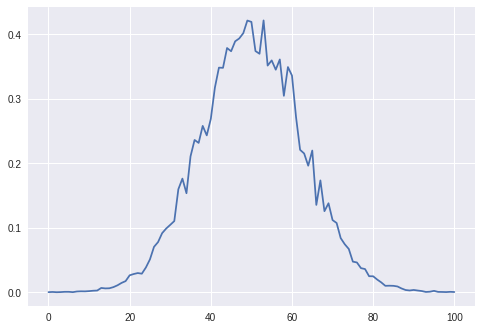

In [11]:
number_of_samples = 10000
rbm = RBM(n_vis=vis, n_hin=hid, k=k, gpu=gpu, saved_weights = saved_weights)

sample = rbm.draw_sample(100, number_of_samples = number_of_samples, initial_im = [])
gauss = sample.mean(0)
gauss = gauss.cpu()
gauss = gauss.detach().numpy()

plt.plot(gauss)
plt.show()

tensor([ 0.0003,  0.0003,  0.0005,  0.0005,  0.0009,  0.0006,  0.0004,
         0.0014,  0.0010,  0.0018,  0.0010,  0.0018,  0.0042,  0.0054,
         0.0064,  0.0045,  0.0092,  0.0106,  0.0153,  0.0179,  0.0239,
         0.0274,  0.0273,  0.0287,  0.0387,  0.0510,  0.0662,  0.0750,
         0.0954,  0.1049,  0.1005,  0.1092,  0.1601,  0.1819,  0.1533,
         0.2077,  0.2316,  0.2340,  0.2523,  0.2428,  0.2668,  0.3142,
         0.3517,  0.3427,  0.3688,  0.3673,  0.3825,  0.3996,  0.3968,
         0.4145,  0.4234,  0.3739,  0.3745,  0.4285,  0.3642,  0.3618,
         0.3512,  0.3644,  0.2985,  0.3486,  0.3323,  0.2694,  0.2229,
         0.2183,  0.2010,  0.2145,  0.1351,  0.1676,  0.1270,  0.1359,
         0.1100,  0.1091,  0.0853,  0.0775,  0.0732,  0.0481,  0.0472,
         0.0423,  0.0407,  0.0270,  0.0239,  0.0197,  0.0160,  0.0112,
         0.0102,  0.0084,  0.0070,  0.0057,  0.0041,  0.0027,  0.0022,
         0.0024,  0.0022,  0.0008,  0.0011,  0.0010,  0.0008,  0.0007,
      